In [ ]:
#@title Print TF version and GPU stats
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.4.0
Found GPU at: /device:GPU:0

Sun Jan 24 12:39:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |    227MiB / 15079MiB |      2%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Set parameters:

*   window_size is a multiple of 78 and less than 450

*   it was decided that foreast time is equial to 500

*   num_epochs = 10, 30, 50

*   batch_size = 64, 128, 256

In [ ]:
window_size   = 156
forecast_time = 500
num_epochs    = 50
batchsize     = 32

# Alternative data: integrate Lorenz system

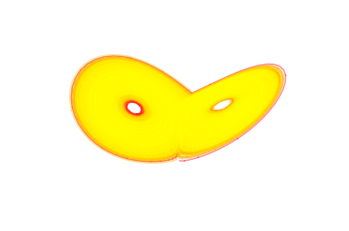

In [ ]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Lorenz paramters and initial conditions
sigma, beta, rho = 10, 2.667, 28
u0, v0, w0 = 0, 1, 1.05

# Maximum time point and total number of time points
tmax, n = 6000, 600000

def lorenz(X0, t, sigma, beta, rho):
    """The Lorenz equations."""
    x, y, z = X0
    xp = sigma * (y - x)
    yp = x * (rho - z) - y
    zp =  x * y - beta * z
    return xp, yp, zp

# Integrate the Lorenz equations on the time grid t
t = np.linspace(0, tmax, n)
f = odeint(lorenz, (u0, v0, w0), t, args=(sigma, beta, rho))
x, y, z = f.T

# Plot the Lorenz attractor using a Matplotlib 3D projection
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
s = 10
c = np.linspace(0,1,n)
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=(1,c[i],0), alpha=0.4)

# Remove all the axis clutter, leaving just the curve.
ax.set_axis_off()

plt.show()

In [ ]:
from scipy import stats
x = stats.zscore(x)
y = stats.zscore(y)
z = stats.zscore(z)

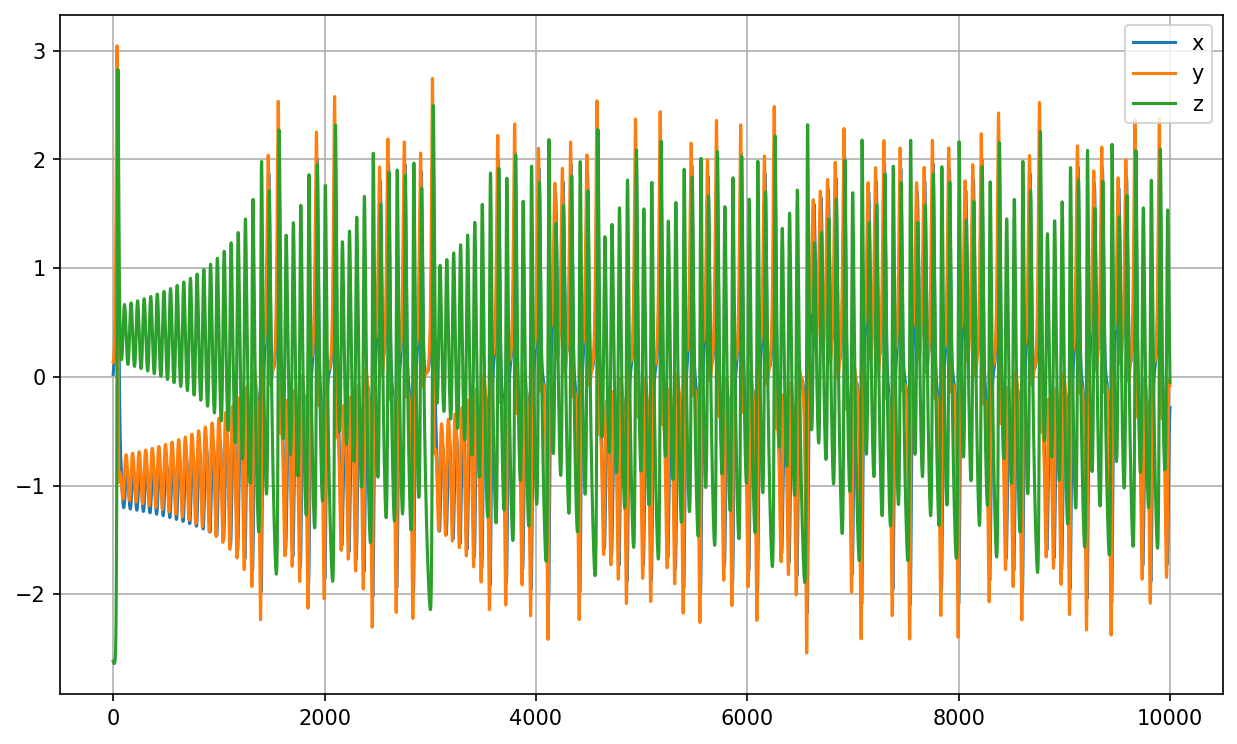

In [ ]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x[:10000], label='x')
plt.plot(y[:10000], label='y')
plt.plot(z[:10000], label='z')
plt.legend()
plt.grid(True)

In [ ]:
data = np.array([x,y,z])
data = np.transpose(data)

# Create dataset

In [ ]:
data.shape

(600000, 3)

In [ ]:
def split_sequence(sequence, n_steps):
    X, Y = list(), list()
    for i in range(0, len(sequence)-1):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix,:], sequence[end_ix,:]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

In [ ]:
X, Y = split_sequence(data, window_size)
end_train = int(np.round(X.shape[0]*0.7))
end_valid = int(np.round(X.shape[0]*(0.7+0.2)))
train_X = X[:end_train]
train_Y = Y[:end_train]
valid_X = X[end_train:end_valid]
valid_Y = Y[end_train:end_valid]
test_X = X[end_valid:]
test_Y = Y[end_valid:]

In [ ]:
#@title Shapes
print('Train X shape - ', train_X.shape, ' train Y shape - ', train_Y.shape)
print('Valid X shape - ', valid_X.shape, '  valid Y shape - ', valid_Y.shape)
print('Test  X shape - ', test_X.shape, '   test Y shape  - ', test_Y.shape)

Train X shape -  (419891, 156, 3)  train Y shape -  (419891, 3)
Valid X shape -  (119969, 156, 3)   valid Y shape -  (119969, 3)
Test  X shape -  (59984, 156, 3)    test Y shape  -  (59984, 3)


# RNN model creation and trainig

We decided to compare the following architectures:



*   one layer with 32 cells
*   two layers with 32 cells
*   three layers with 32 cells
*   one layer with 312 cells



In [ ]:
from keras import Model, layers, Input
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import EarlyStopping

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
es = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=True)

In [ ]:
def build_lstm_model(input_shape, summary=True):
  
    inputs = Input(shape=input_shape)
    
    # If one layer use:
    x = layers.LSTM(32, activation='tanh', dropout=.2)(inputs)

    # If two layers use:
    # x = layers.LSTM(32, activation='tanh', dropout=.2, return_sequences=True)(inputs)
    # x = layers.LSTM(32, activation='tanh', dropout=.2)(x)


    # If three layers use:
    # x = layers.LSTM(32, activation='tanh', dropout=.2, return_sequences=True)(inputs)
    # x = layers.LSTM(32, activation='tanh', dropout=.2, return_sequences=True)(x)
    # x = layers.LSTM(32, activation='tanh', dropout=.2)(x)

    # Other used architecture examples
    # GRU with 2 layers:
    # x = layers.GRU(32, activation='tanh', dropout=.2, return_sequences=True)(inputs)
    # x = layers.GRU(32, activation='tanh', dropout=.2)(x)

    # SimpleRNN with 1 layer:
    # x = layers.SimpleRNN(32, activation='tanh', dropout=.2)(inputs)

    # BidirectionalLSTM with 2 layers
    # x = layers.Bidirectional(LSTM(32, activation='tanh', dropout=.2, return_sequences=True))(inputs)
    # x = layers.Bidirectional(LSTM(32, activation='tanh', dropout=.2))(x)

    output = layers.Dense(3)(x)
    
    model = Model(inputs=inputs, outputs=output, name="lstm_model")
    model.compile(loss='mse',
                optimizer="RMSprop",
                metrics=['accuracy'])
    if summary:
        print(model.summary())
    
    return model
    

In [ ]:
lstm_model = build_lstm_model((window_size,3))

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 156, 3)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 156, 32)           4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 13,027
Trainable params: 13,027
Non-trainable params: 0
_________________________________________________________________
None


Training

In [ ]:
tf.keras.backend.clear_session()
lstm_history = lstm_model.fit(train_X, train_Y, 
                              epochs=num_epochs, 
                              batch_size=batchsize, 
                              validation_data=(valid_X, valid_Y), 
                              shuffle=True,
                              callbacks=[es])

Epoch 1/50
13122/13122 [==============================] - 206s 15ms/step - loss: 0.0144 - accuracy: 0.9489 - val_loss: 0.0139 - val_accuracy: 0.9552
Epoch 2/50
13122/13122 [==============================] - 195s 15ms/step - loss: 0.0012 - accuracy: 0.9800 - val_loss: 0.0136 - val_accuracy: 0.9438
Epoch 3/50
13122/13122 [==============================] - 195s 15ms/step - loss: 6.5680e-04 - accuracy: 0.9852 - val_loss: 0.0094 - val_accuracy: 0.9414
Epoch 4/50
13122/13122 [==============================] - 195s 15ms/step - loss: 4.8146e-04 - accuracy: 0.9870 - val_loss: 0.0109 - val_accuracy: 0.9477
Epoch 5/50
13122/13122 [==============================] - 194s 15ms/step - loss: 3.9226e-04 - accuracy: 0.9883 - val_loss: 0.0095 - val_accuracy: 0.9549
Epoch 6/50
13122/13122 [==============================] - 194s 15ms/step - loss: 3.3275e-04 - accuracy: 0.9890 - val_loss: 0.0091 - val_accuracy: 0.9465
Epoch 7/50
13122/13122 [==============================] - 194s 15ms/step - loss: 2.8937e-0

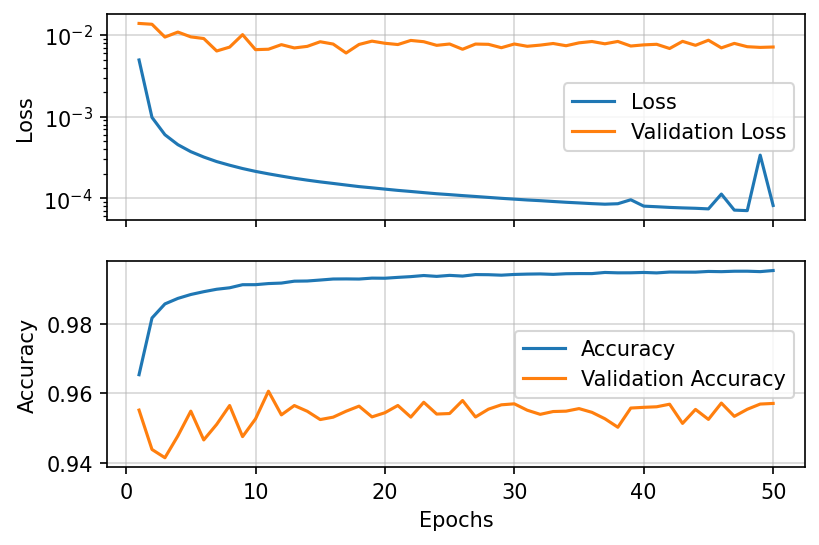

In [ ]:
#@title Plot history
def plot_history(history, ylim=None):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(np.array(history.epoch)+1, history.history['loss'], label='Loss')
  ax1.plot(np.array(history.epoch)+1, history.history['val_loss'], label='Validation Loss')
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_yscale('log')
  ax1.grid(alpha=.5)
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(np.array(history.epoch)+1, history.history['accuracy'], label='Accuracy')
  ax2.plot(np.array(history.epoch)+1, history.history['val_accuracy'], label='Validation Accuracy')
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid(alpha=.5)
  if ylim:
    ax2.set_ylim(ylim)
  #ax2.legend()
  plt.show() 

plot_history(lstm_history)

# One step ahead forecasting

In [ ]:
forecast = lstm_model.predict(test_X)
print(forecast.shape)

(59984, 3)


In [ ]:
errorX = root_mean_squared_error(test_Y[:, 0], forecast[:, 0]).numpy()
print('RMSE X =', errorX)
errorY = root_mean_squared_error(test_Y[:, 1], forecast[:, 1]).numpy()
print('RMSE Y =', errorY)
errorZ = root_mean_squared_error(test_Y[:, 2], forecast[:, 2]).numpy()
print('RMSE Z =', errorZ)
errorAVG = (errorX + errorY + errorZ)/3
print('Average RMSE =', errorAVG)

RMSE X = 0.06546421294857137
RMSE Y = 0.08132633012475626
RMSE Z = 0.10236922590405127
Average RMSE = 0.08305325632579297


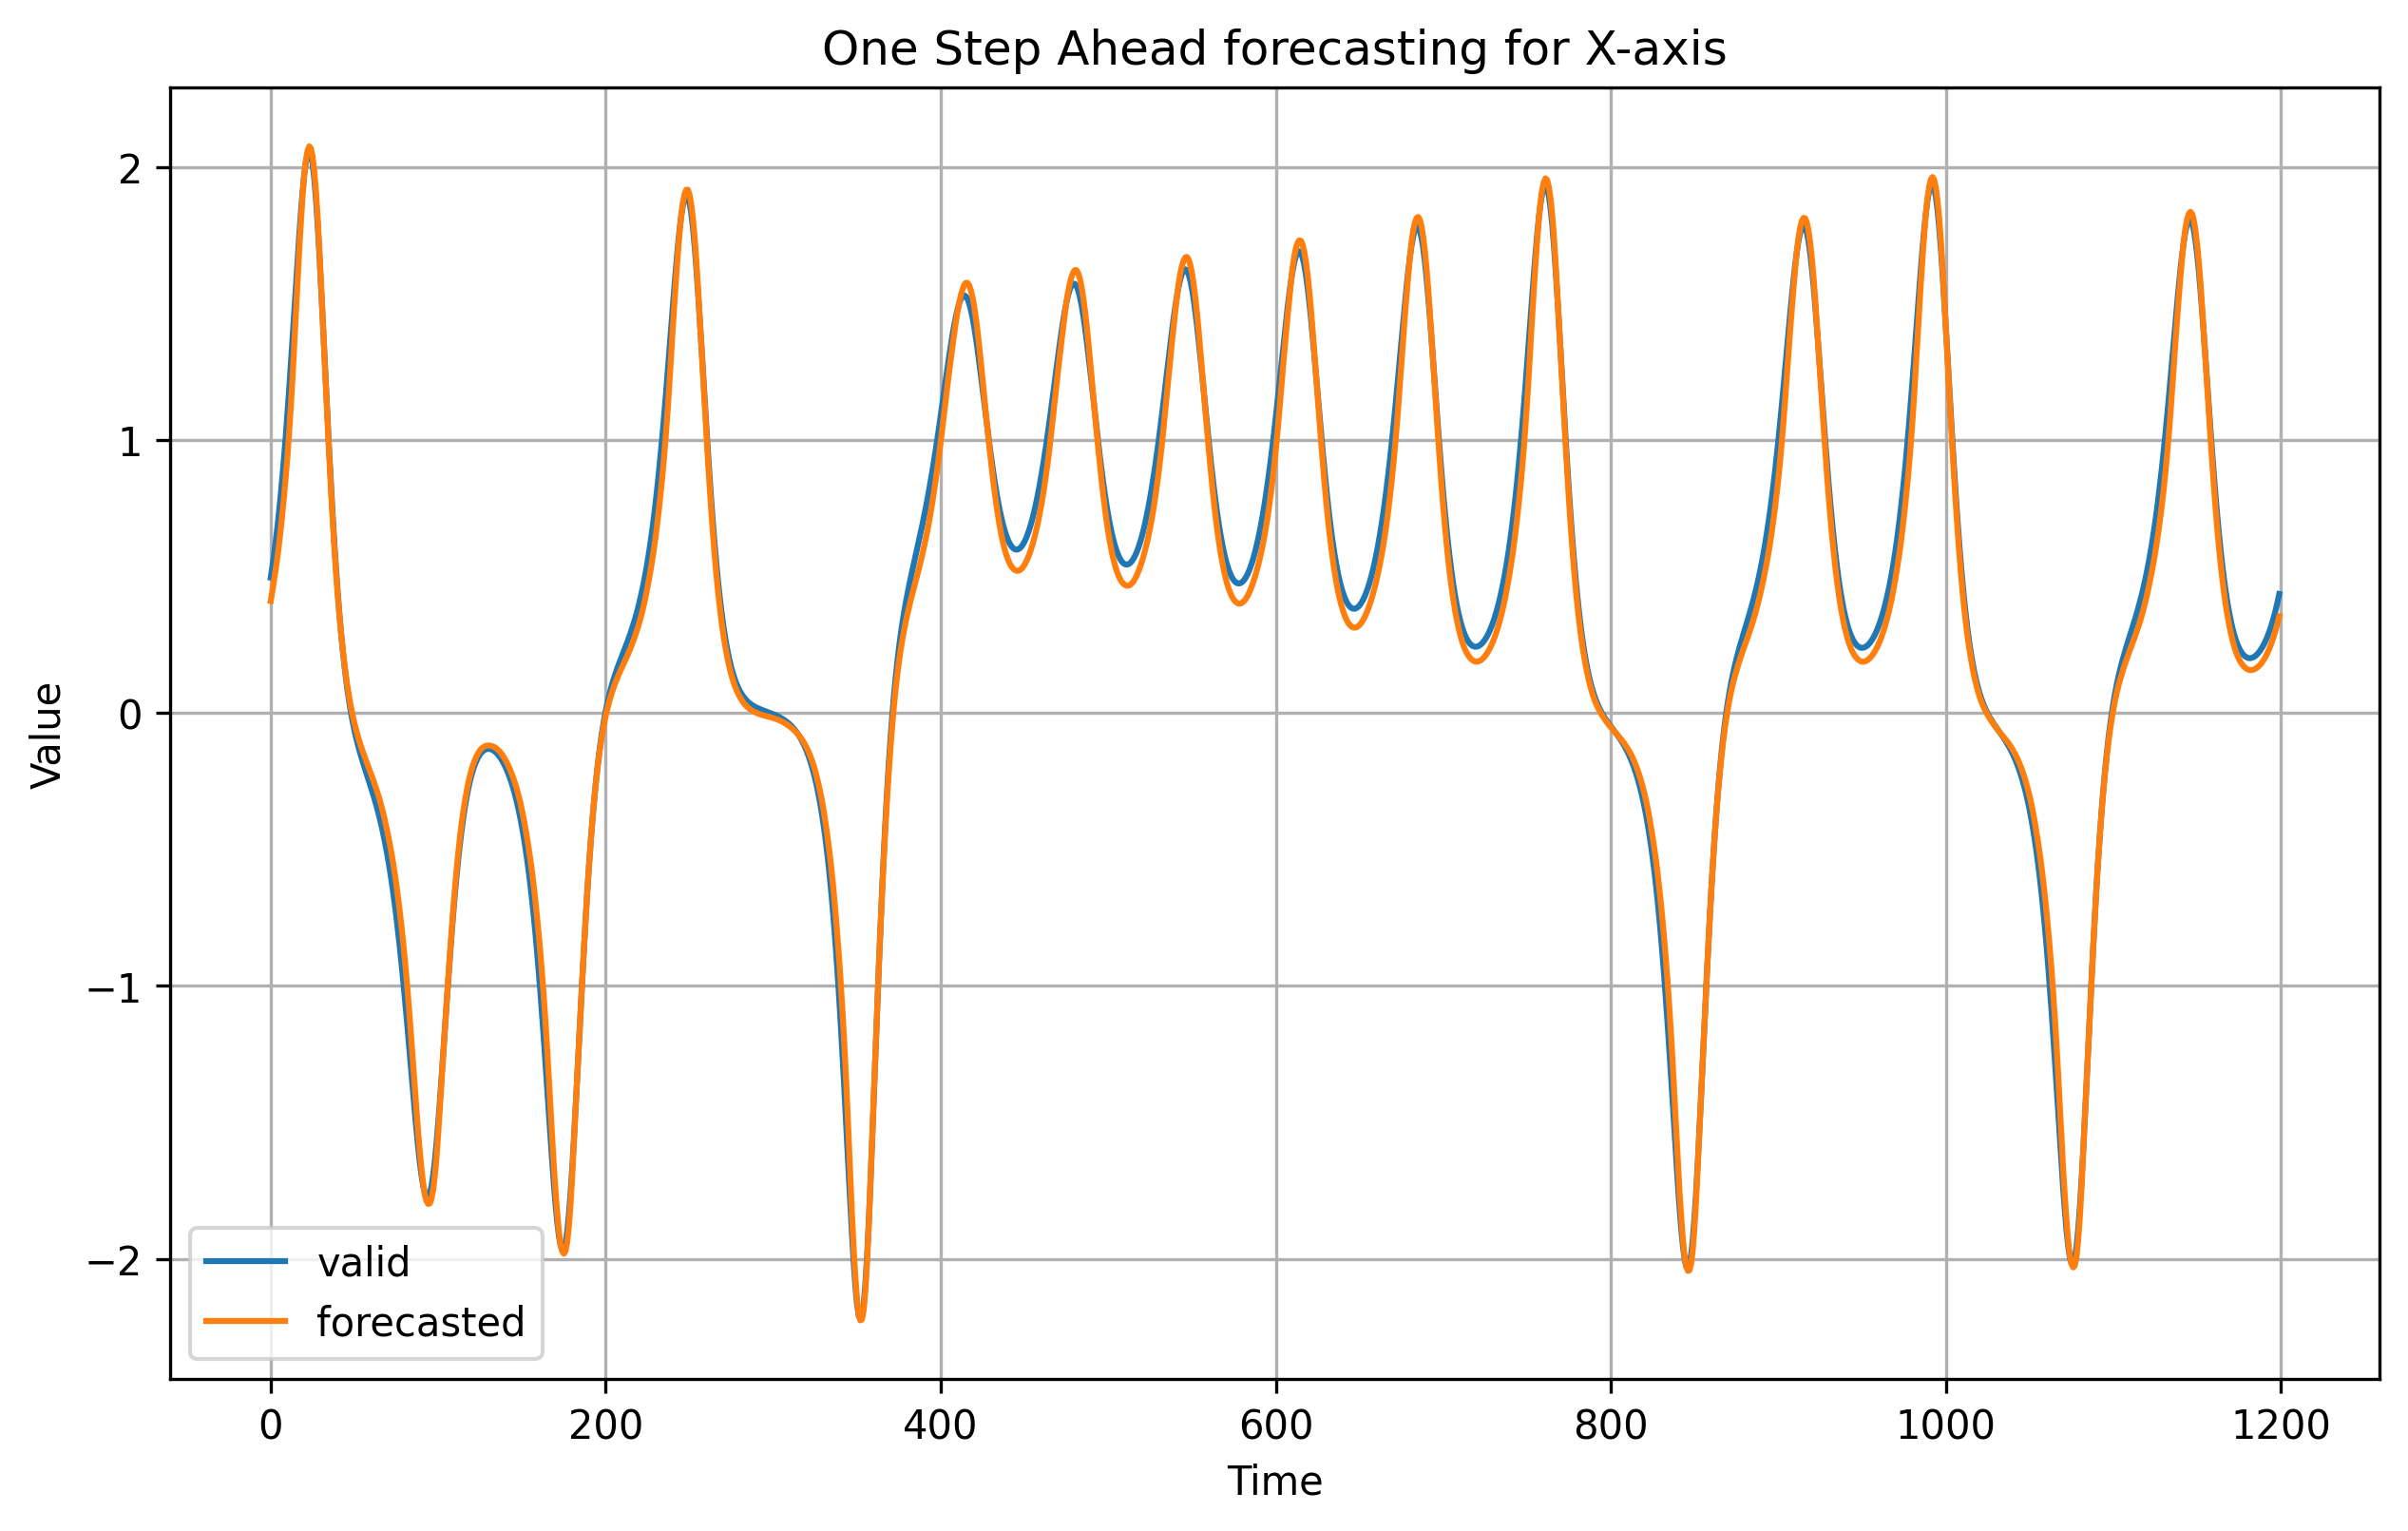

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_Y[:1200, 0], label='valid')
plt.plot(forecast[:1200, 0], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('One Step Ahead forecasting for X-axis')
plt.grid(True)


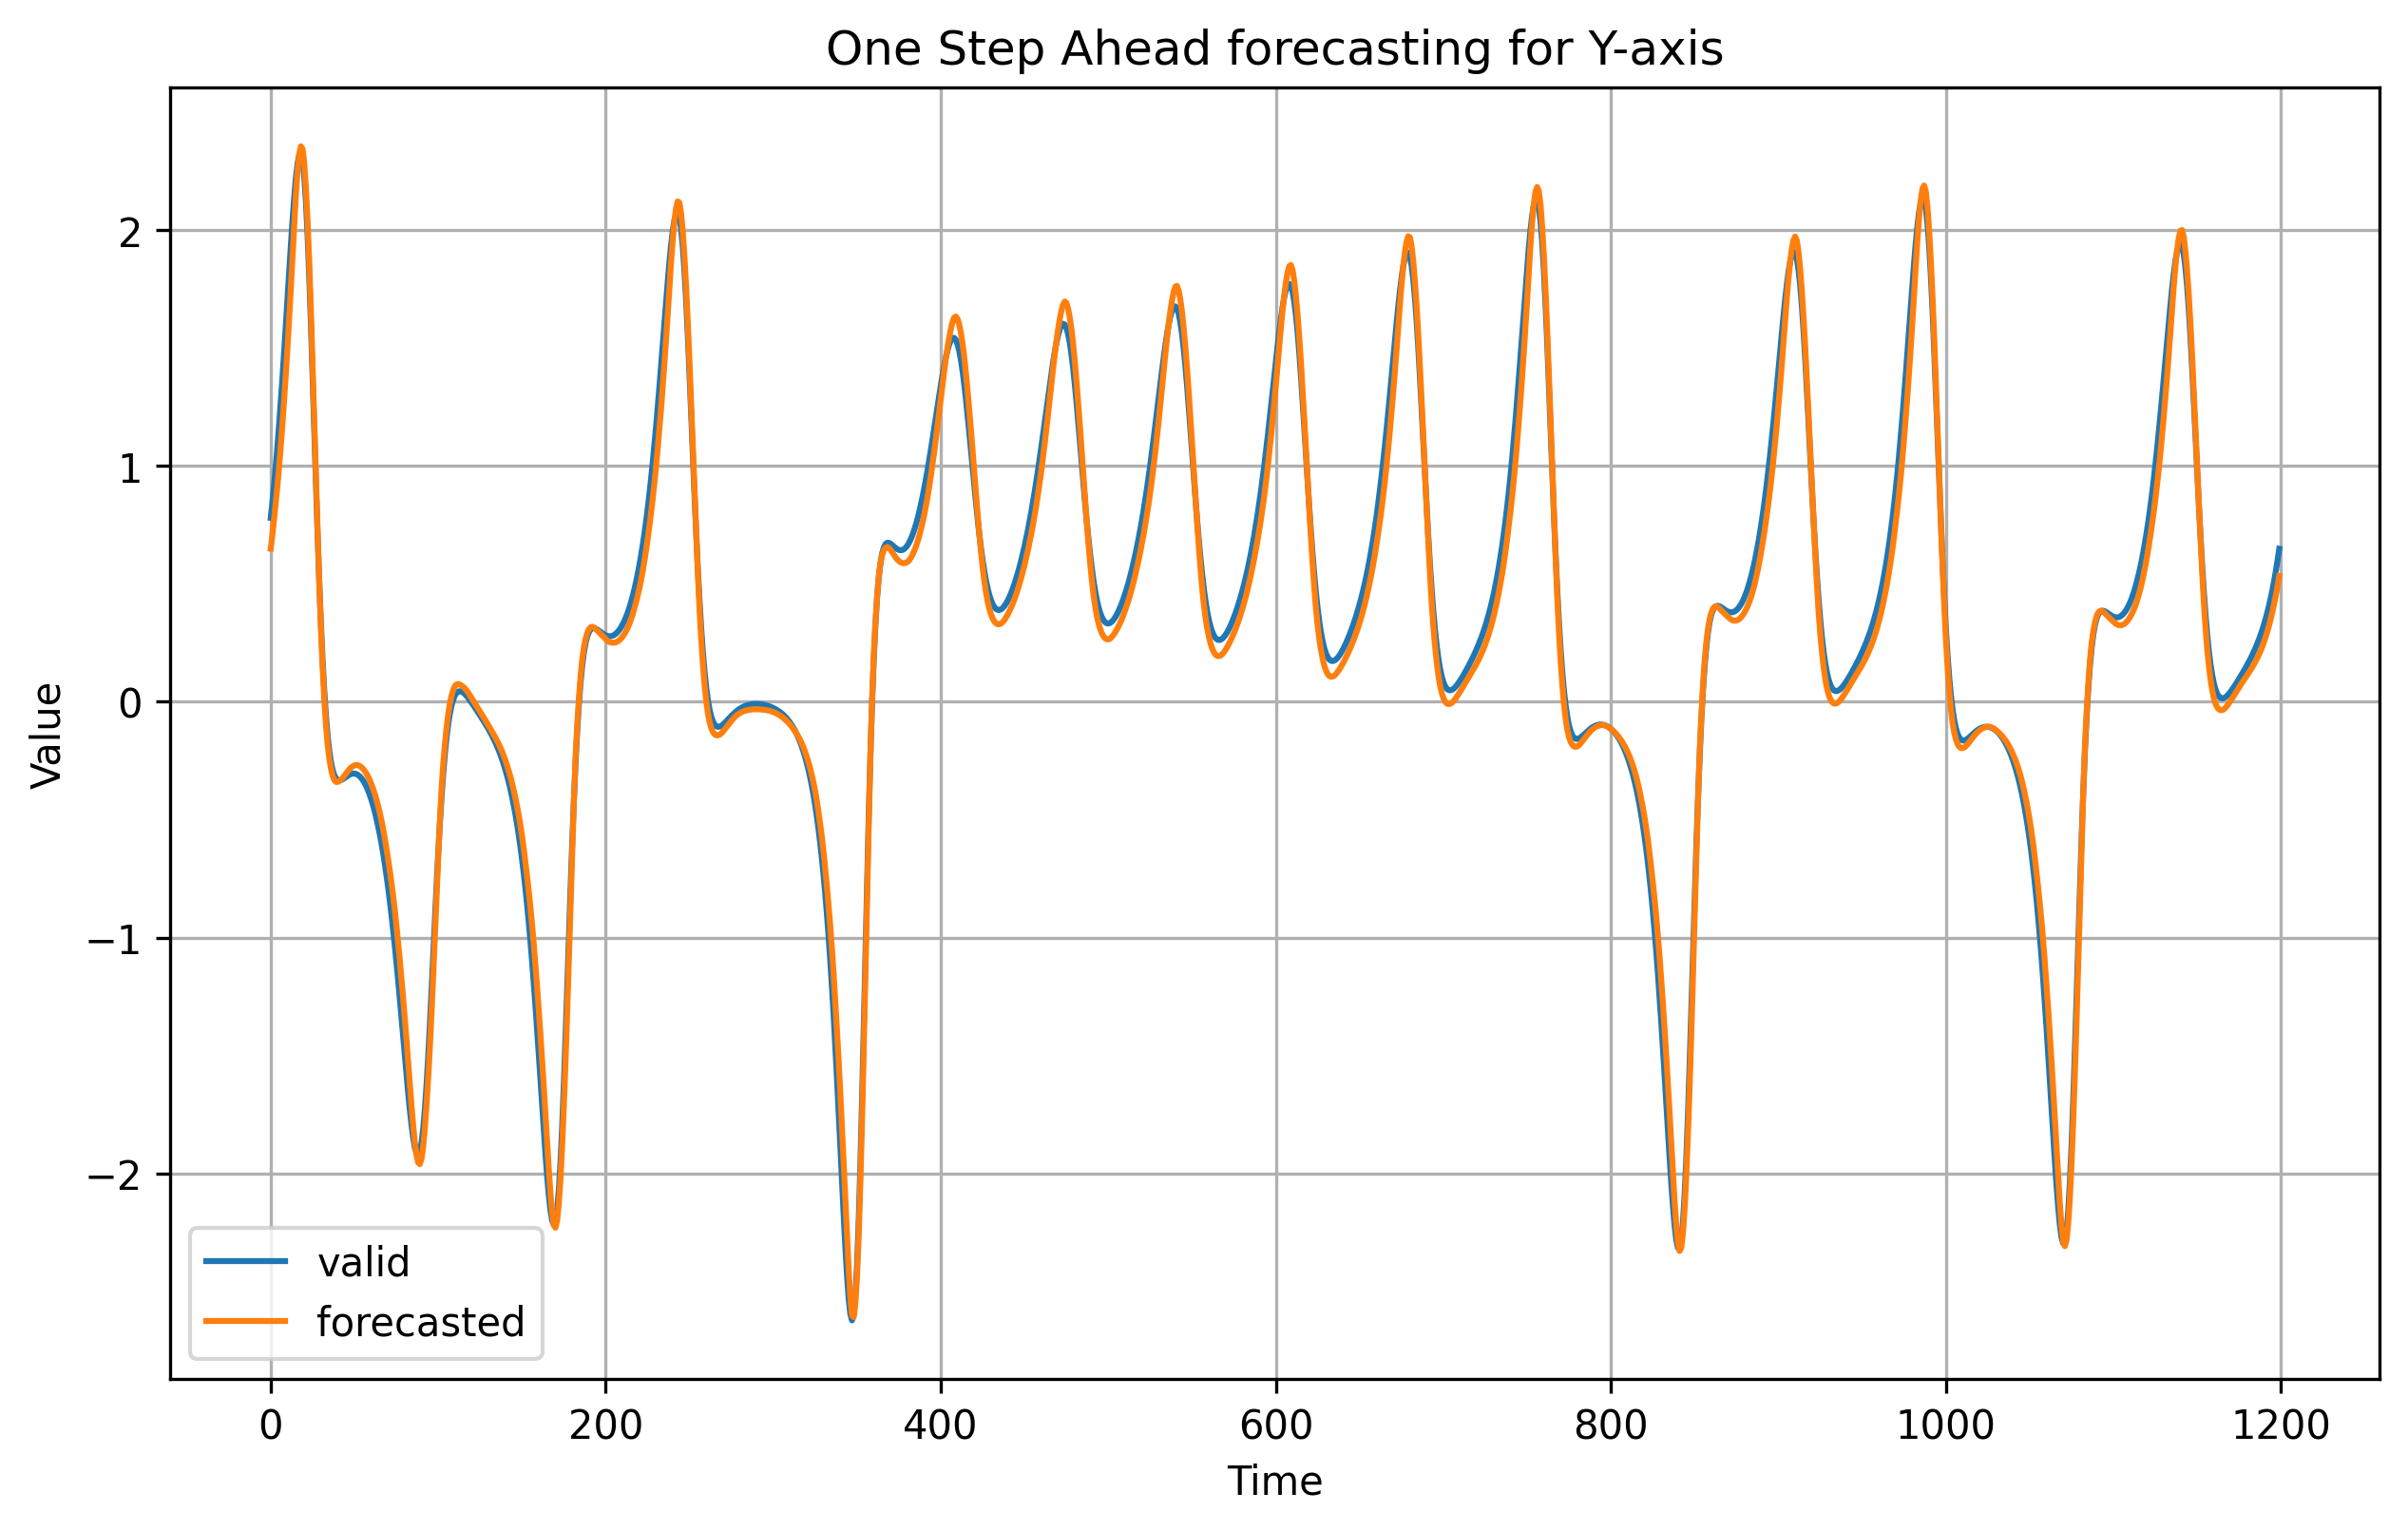

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_Y[:1200, 1], label='valid')
plt.plot(forecast[:1200, 1], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('One Step Ahead forecasting for Y-axis')
plt.grid(True)

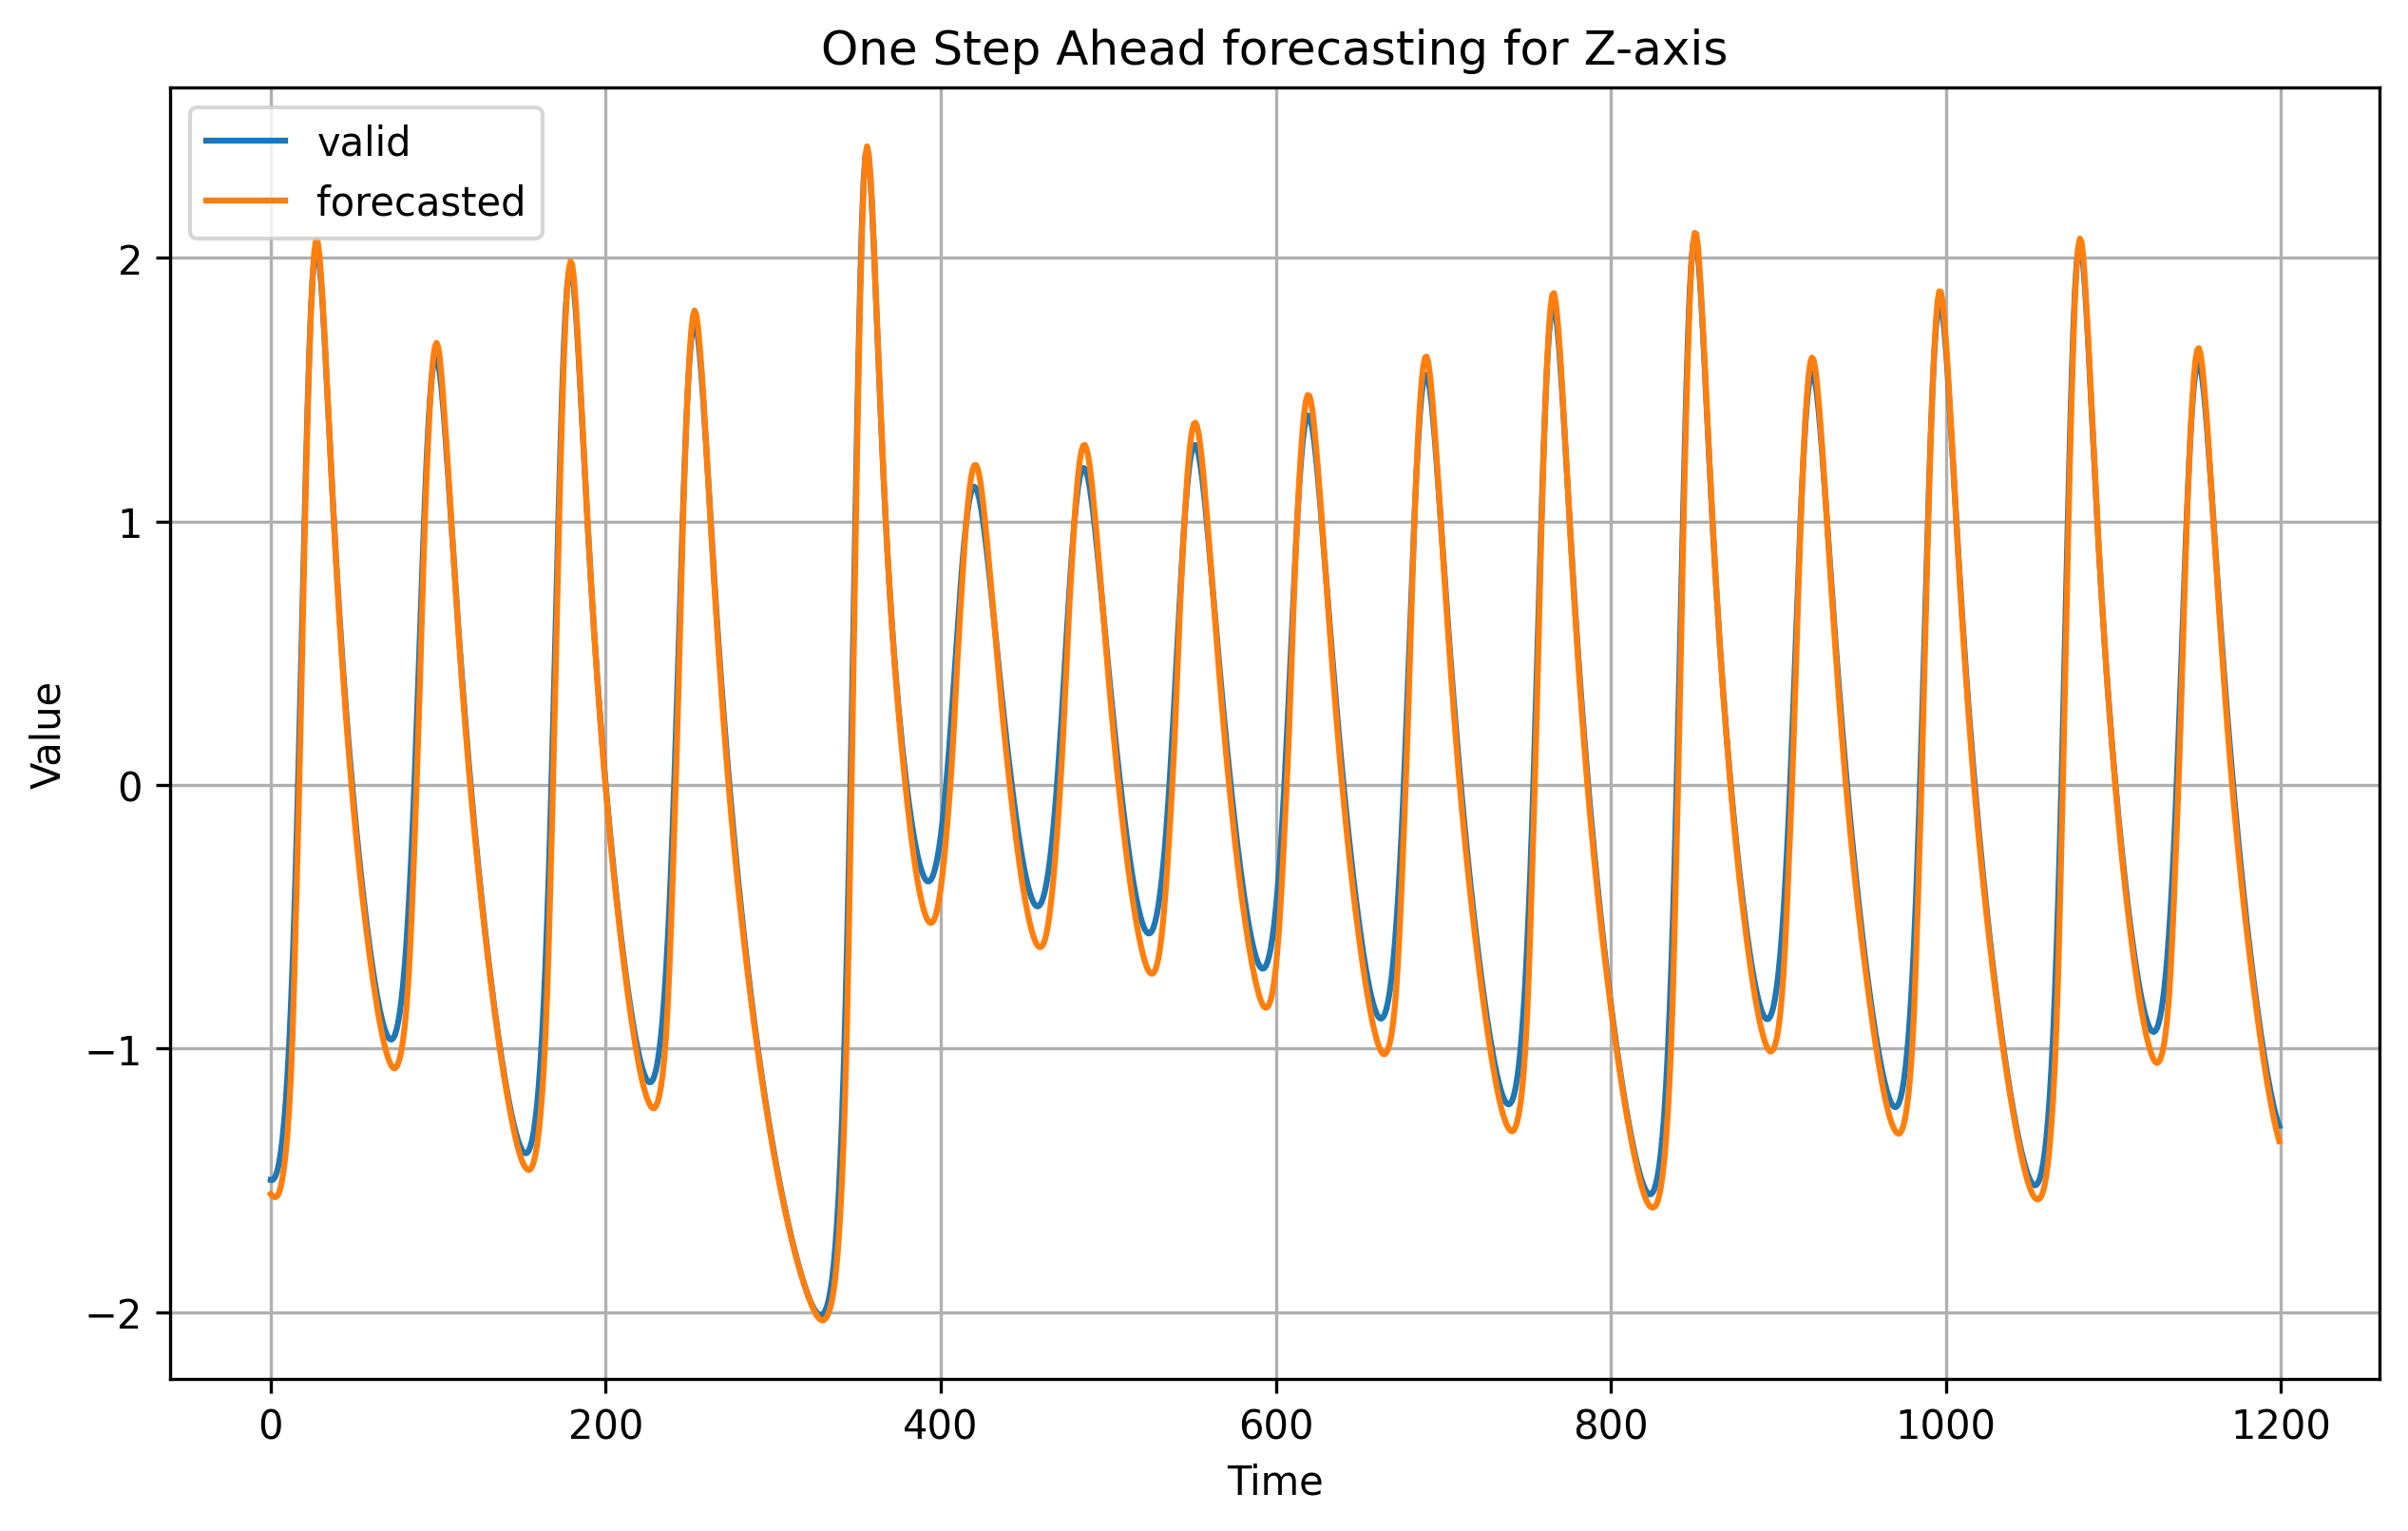

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_Y[:1200, 2], label='valid')
plt.plot(forecast[:1200, 2], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('One Step Ahead forecasting for Z-axis')
plt.grid(True)

# Multiple step ahead forecasting

We use values predicted by RNN to forecast multiple steps ahead

In [ ]:
# forecast multiple step

def forecast_mult_step(forecast_time, window_size, X, Y, model):
  if len(test_Y) - forecast_time < window_size : # check the possibility of forecasting
    print('Choose another time')
  else:
    Y_mult = np.empty(shape=[0, 3]) # create empty array for storing forecasted Y values
    forecast_mult = test_X[:1, :, :] # copy data for the first time step prediction
    for time in range(forecast_time):
      y = model.predict(forecast_mult[time:time+1,:,:]) # predict Y value
      Y_mult = np.append(Y_mult, y, axis=0) # save Y value
      # print(y)
      forecast_mult = np.append(forecast_mult, np.empty(shape=[1, window_size, 3]), axis=0) # add new empty sample 
      forecast_mult[time+1, :window_size-1, :] = forecast_mult[time, 1:window_size, :] # copy values from previous step except the last value
      forecast_mult[time+1, window_size-1, :] = y # add predicted value

  return Y_mult
  #print(forecast_mult.shape)
  #print(Y_mult.shape)

In [ ]:
Y_mult = forecast_mult_step(forecast_time, window_size, test_X, test_Y, lstm_model)

In [ ]:
errorX = root_mean_squared_error(test_Y[:forecast_time, 0], Y_mult[:, 0]).numpy()
print('RMSE X =', errorX)
errorY = root_mean_squared_error(test_Y[:forecast_time, 1], Y_mult[:, 1]).numpy()
print('RMSE Y =', errorY)
errorZ = root_mean_squared_error(test_Y[:forecast_time, 2], Y_mult[:, 2]).numpy()
print('RMSE Z =', errorZ)
errorAVG = (errorX + errorY + errorZ)/3
print('Average RMSE =', errorAVG)

RMSE X = 1.0219732836619688
RMSE Y = 1.0912805619564512
RMSE Z = 1.518144606830025
Average RMSE = 1.2104661508161483


Forecast for X

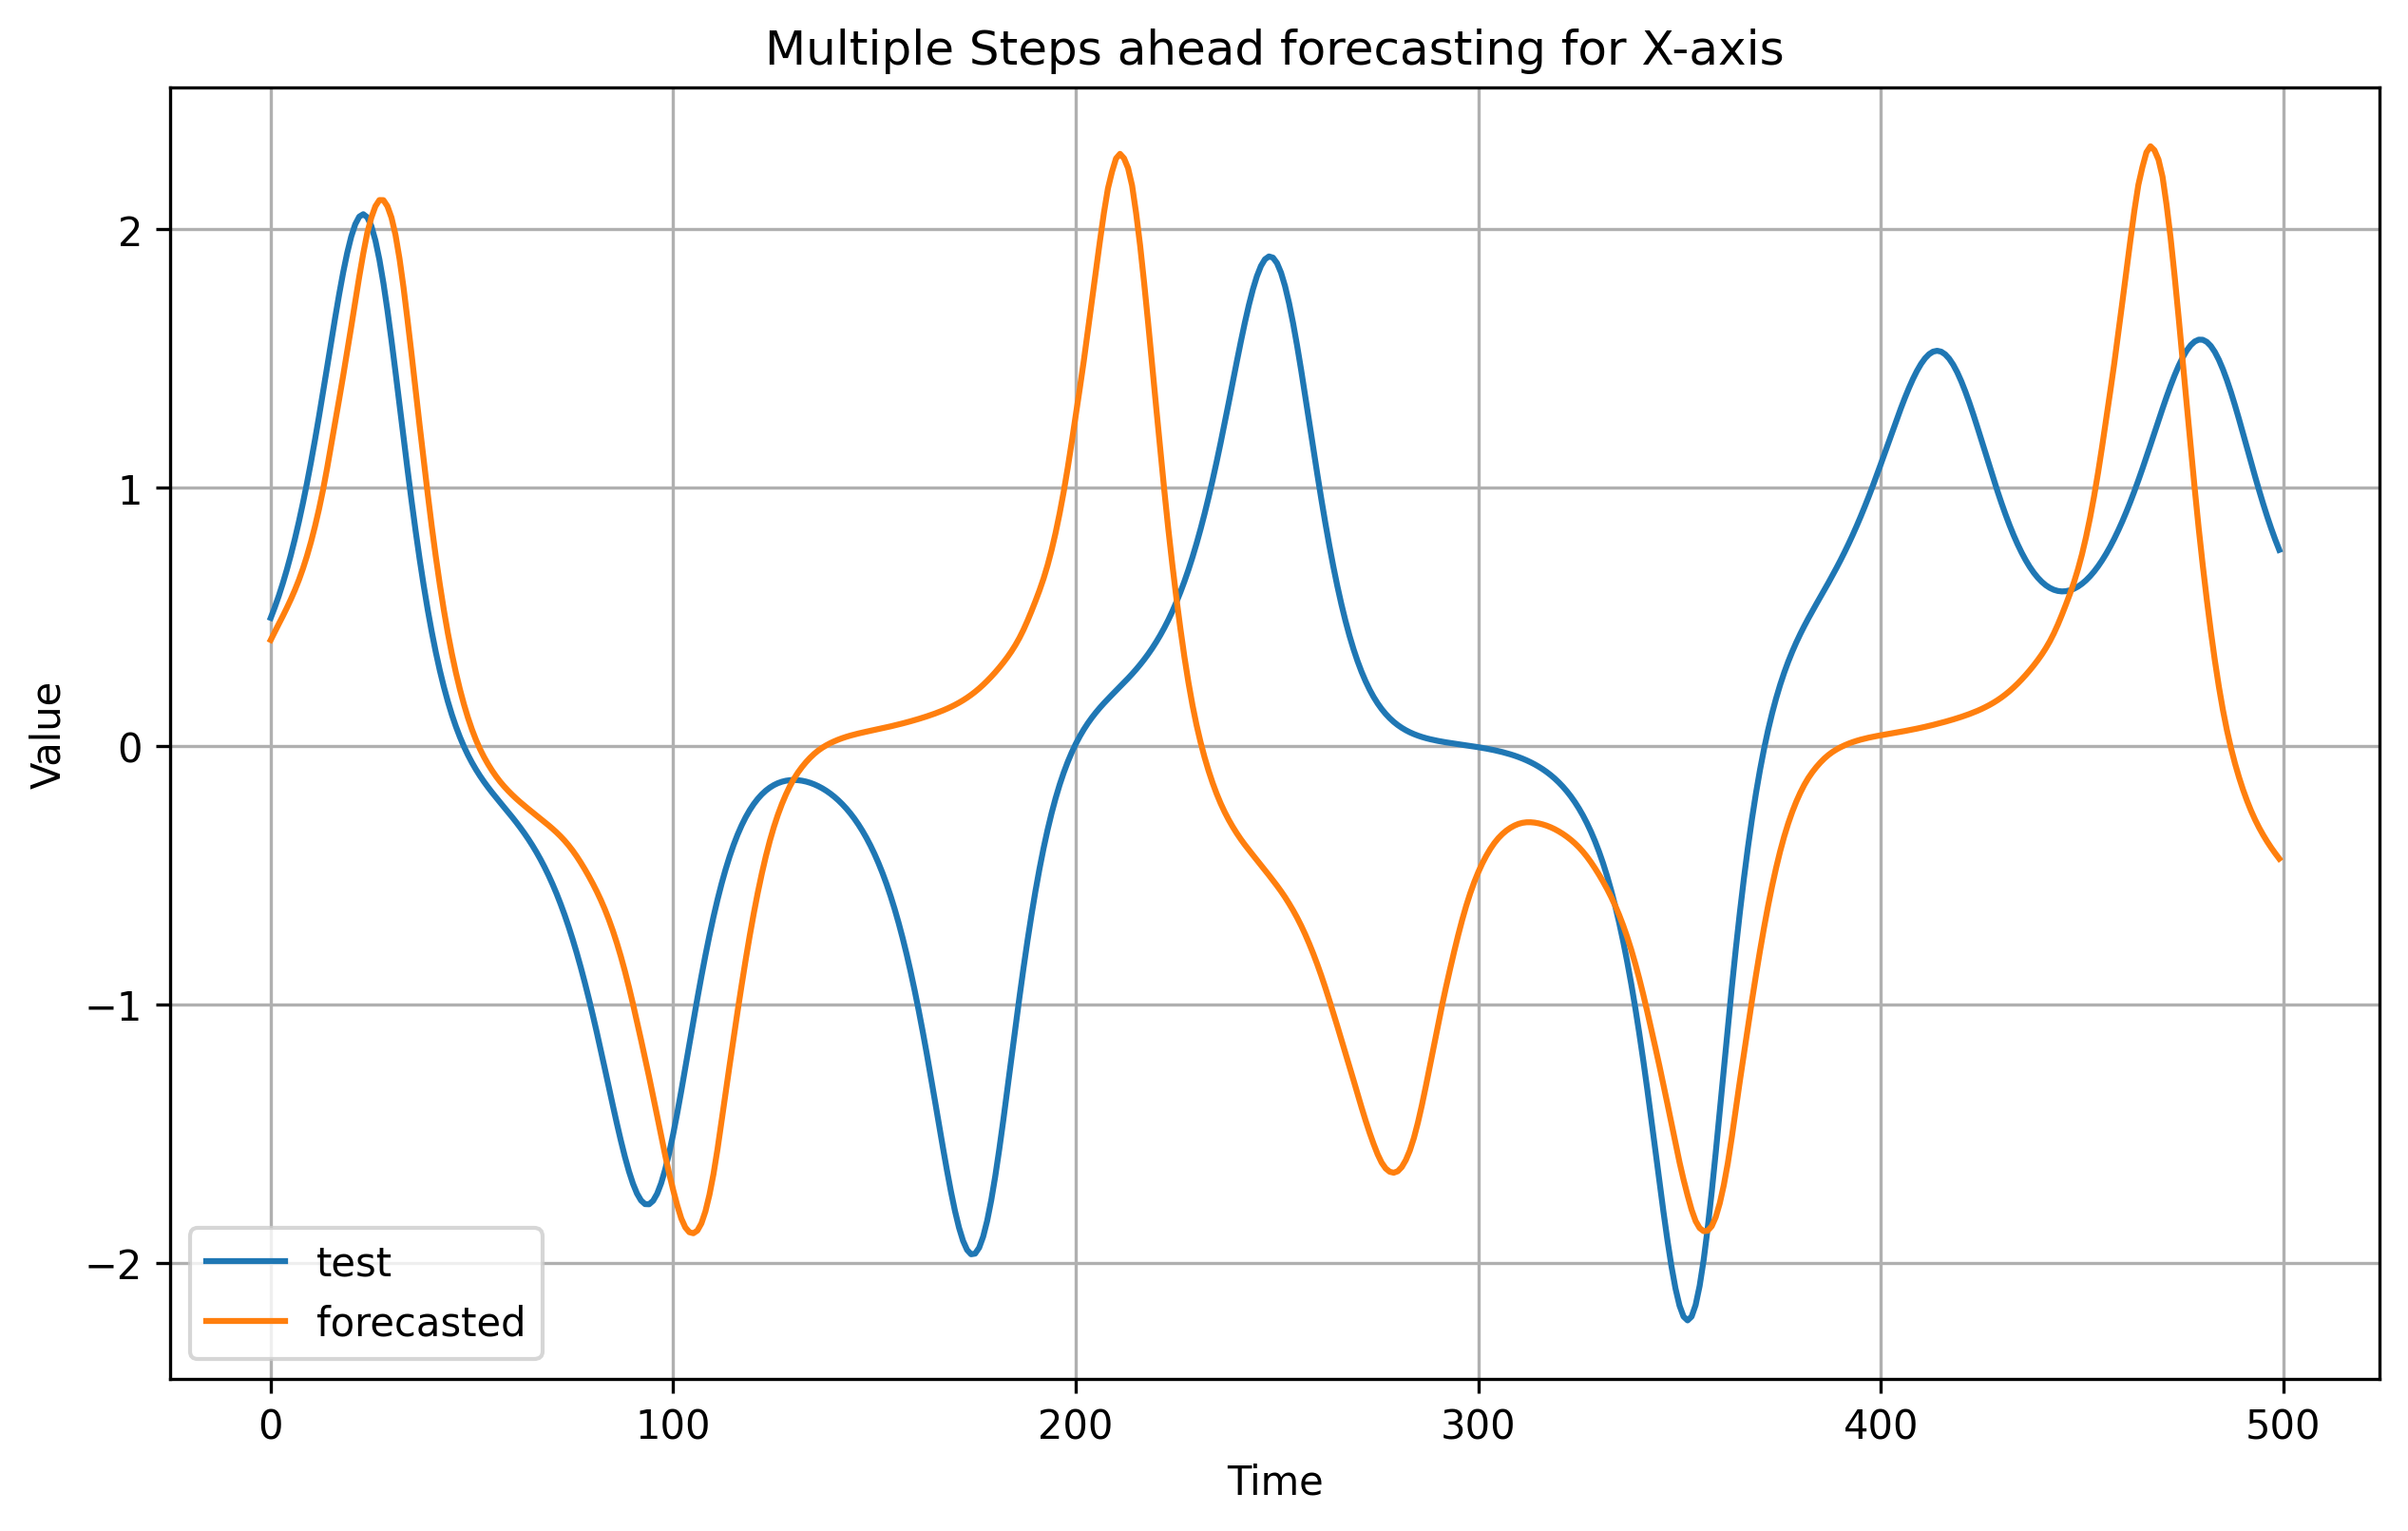

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_Y[:forecast_time, 0], label='test')
plt.plot(Y_mult[:, 0], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Multiple Steps ahead forecasting for X-axis')
plt.grid(True)

Forecast for Y

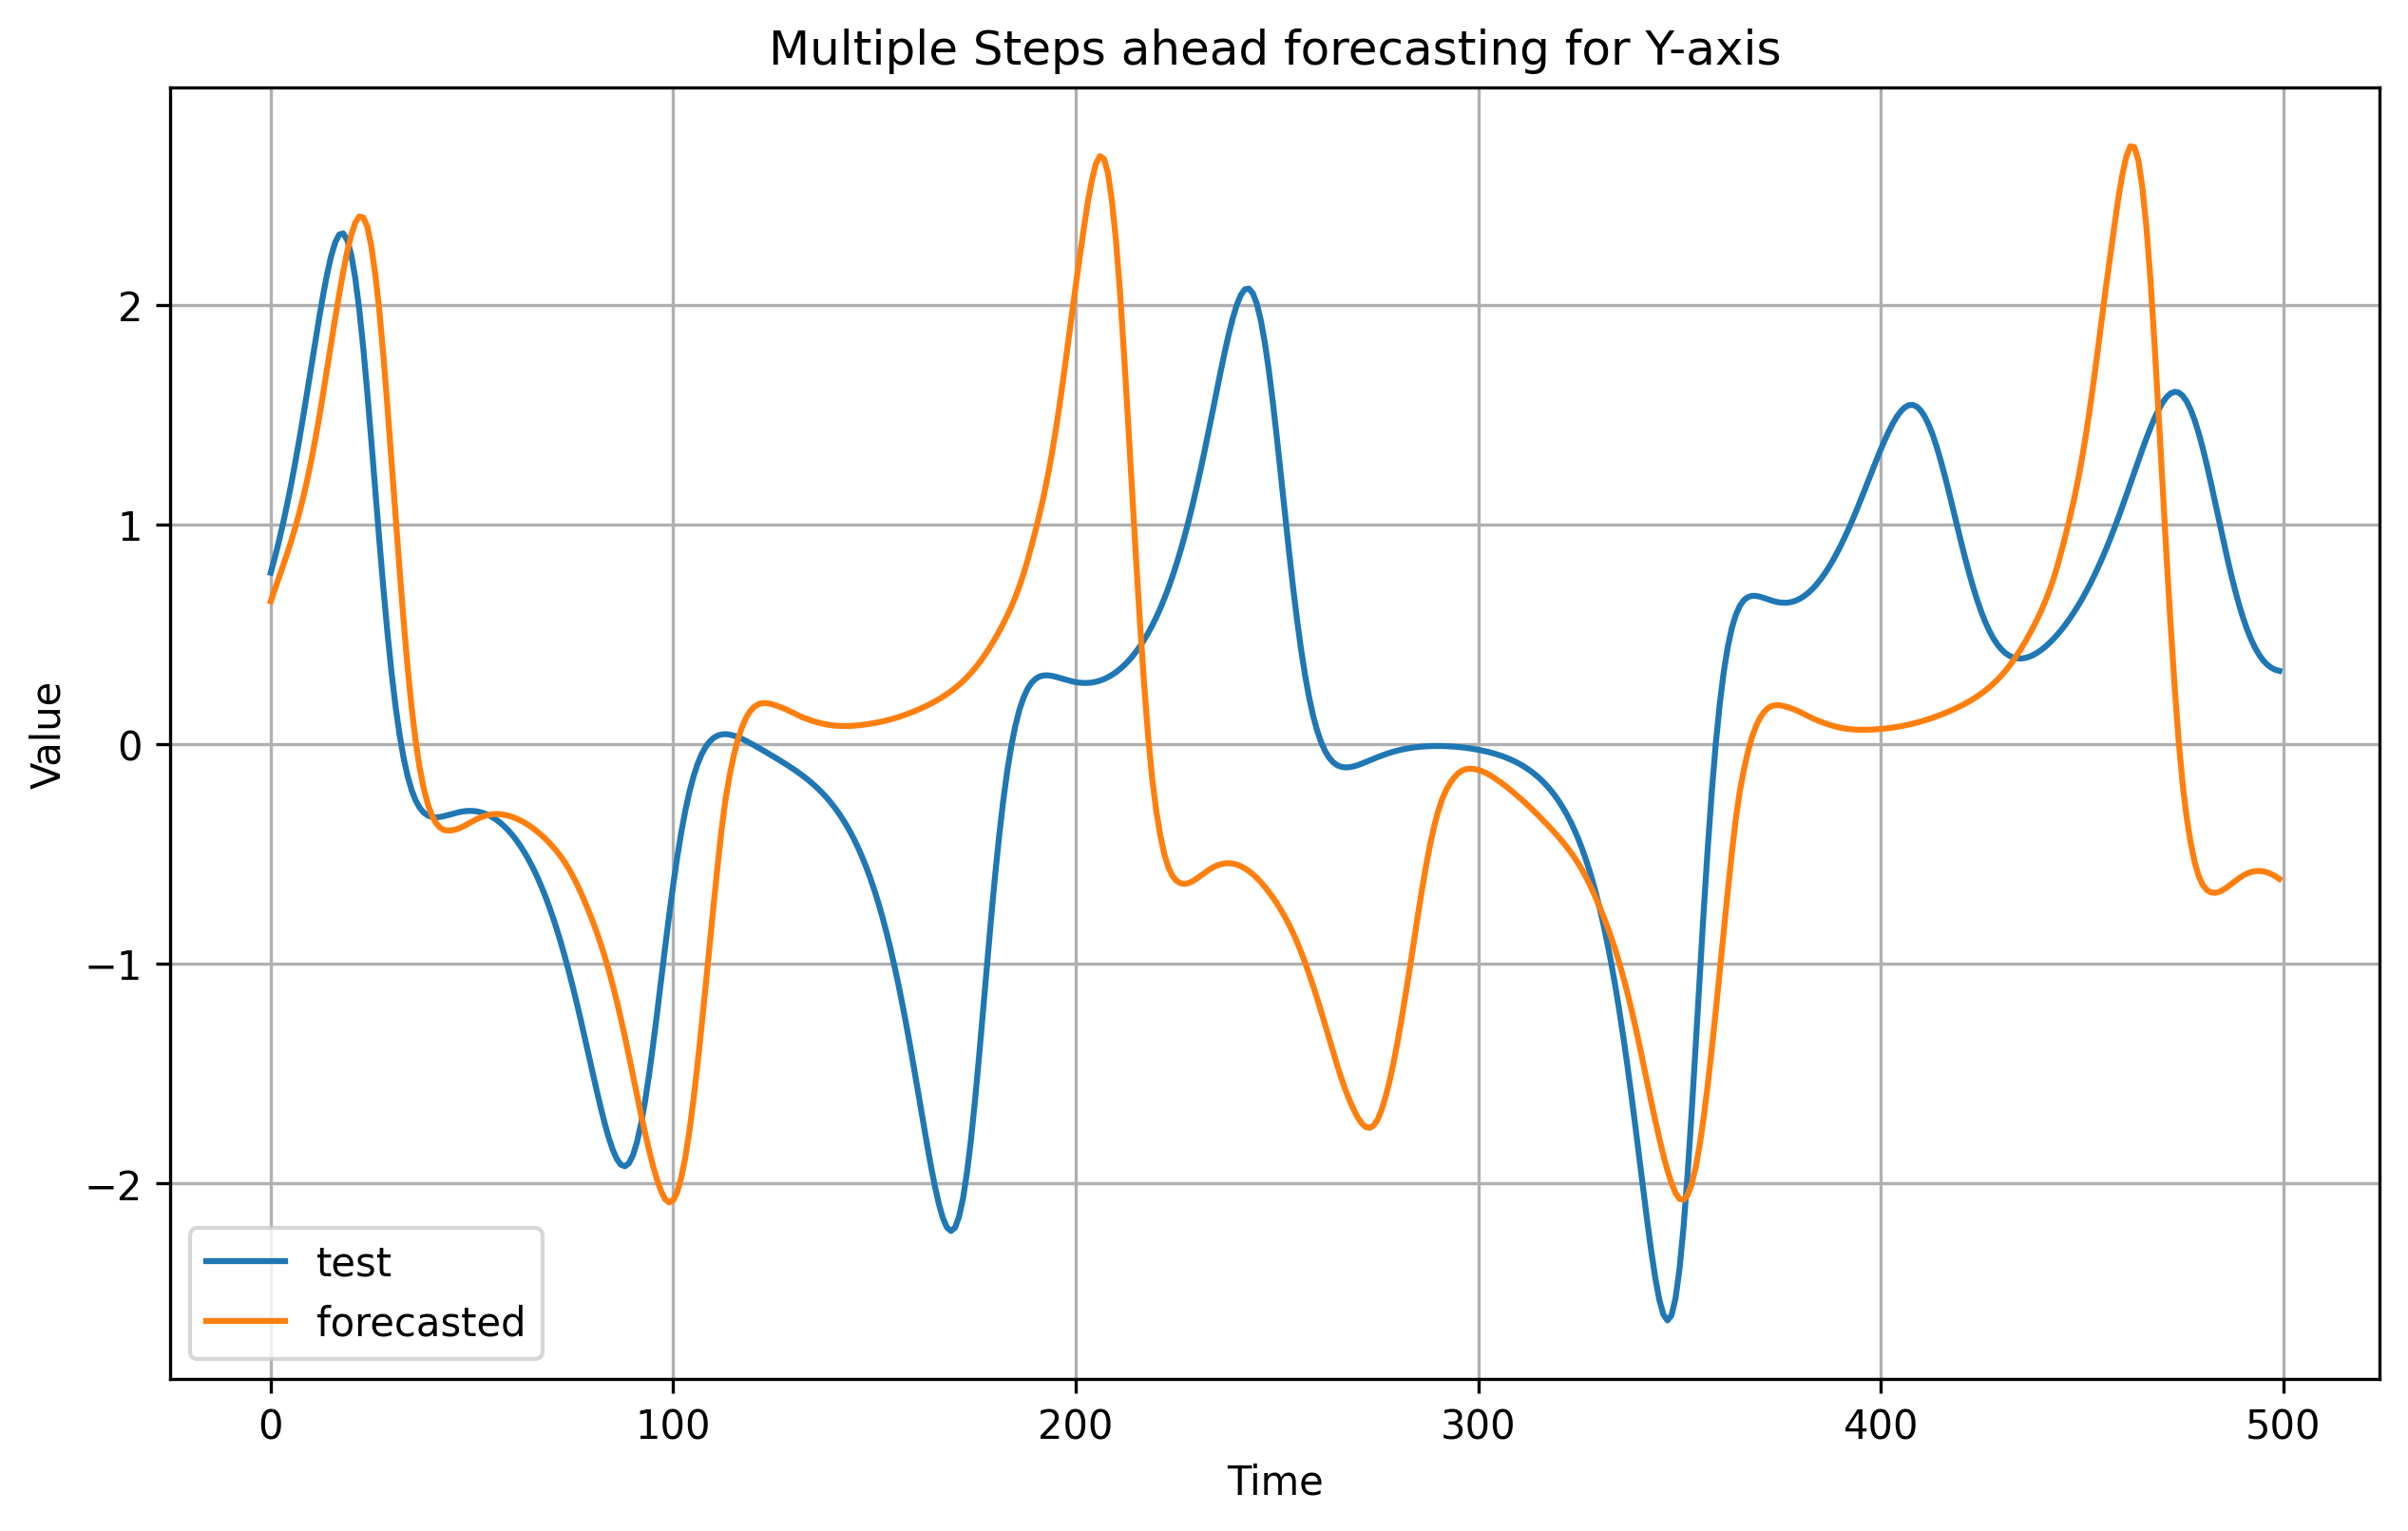

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_Y[:forecast_time, 1], label='test')
plt.plot(Y_mult[:, 1], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Multiple Steps ahead forecasting for Y-axis')
plt.grid(True)

Forecast for Z

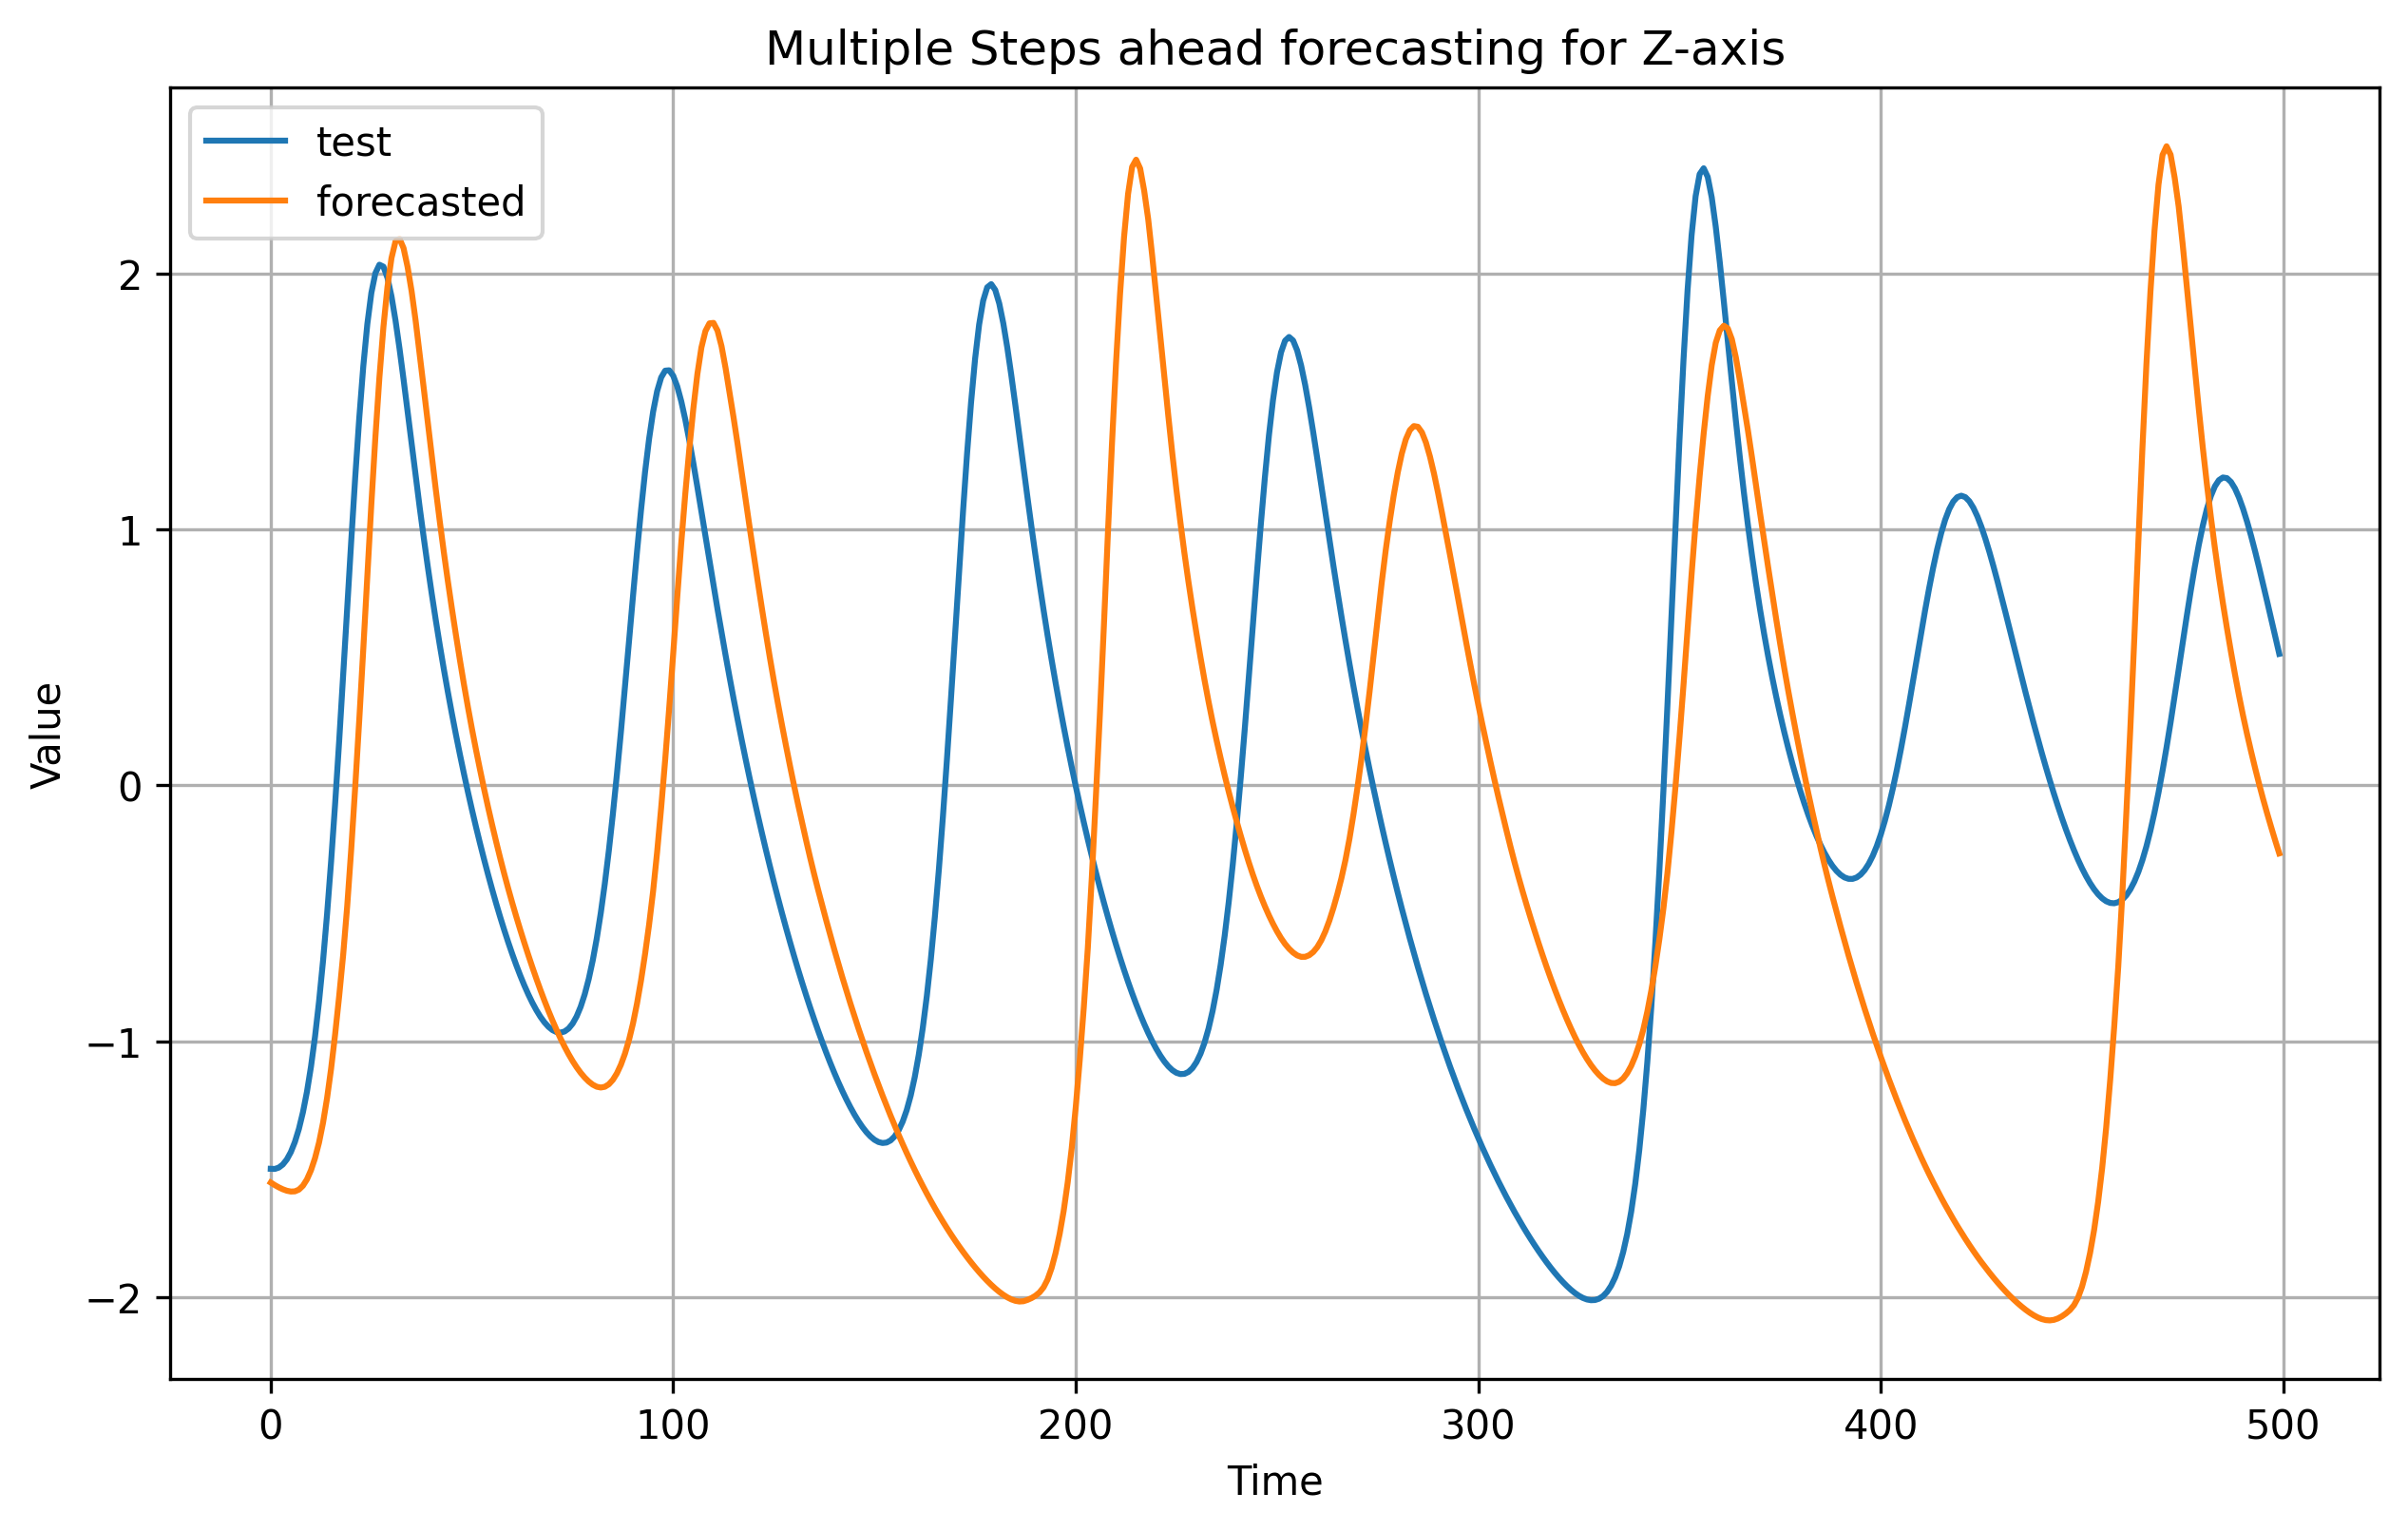

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_Y[:forecast_time, 2], label='test')
plt.plot(Y_mult[:, 2], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Multiple Steps ahead forecasting for Z-axis')
plt.grid(True)